In [1]:
#Import library
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import re
import seaborn as sns
import sklearn
from sklearn import linear_model, metrics, preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import itertools
from sklearn.ensemble import RandomForestRegressor

# --------cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# --------  metrics:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,r2_score
from sklearn.metrics import make_scorer

# --------  time:
import time

In [ ]:
pip install selenium

In [ ]:
#Selenium imports
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

#Run the load more CSS script and crawling all of the links from the site
DRIVER_PATH=r'C:\Users\שמעון\Downloads\chromedriver.exe'
driver = webdriver.Chrome(executable_path=DRIVER_PATH)
driver.get('https://google.com')
options = Options()
options.headless = True
options.add_argument("--window-size=1920,1200")
driver.get("https://gadgets.ndtv.com/mobiles/phone-finder")
for i in range (305):
    driver.execute_script("arguments[0].click();", WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, "//a[@class='load-more _btn']"))))
    time.sleep(5)
elem_list = driver.find_elements_by_class_name('_flspc')
url_list=[i.get_attribute('href') for i in elem_list]
print(len(elem_list))
print(len(url_list))
print(url_list)
driver.quit()


In [ ]:
#Crawl every instance of device and save it into DataFrame
result=pd.DataFrame()
for phone in range(len(url_list)):
    try:
        DRIVER_PATH=r'C:\Users\שמעון\Downloads\chromedriver.exe'
        driver = webdriver.Chrome(executable_path=DRIVER_PATH)
        driver.get('https://google.com')
        options = Options()
        options.headless = True
        options.add_argument("url_list--window-size=1920,1200")
        driver.get(url_list[phone])
        data=[]
        dic={}
        for i in range(1,10):
            try:
                rows = len(driver.find_elements_by_xpath('//*[@id="specs"]/div[{}]/table/tbody/tr'.format(i)))
                exc_num=0
                for j in range(1,rows):
                    try:
                        criteria=driver.find_element_by_xpath('//*[@id="specs"]/div[{}]/table/tbody/tr[{}]/td[1]'.format(i,j)).text
                        value=driver.find_element_by_xpath('//*[@id="specs"]/div[{}]/table/tbody/tr[{}]/td[2]'.format(i,j)).text
                        if(exc_num<=1):
                            dic[criteria]=value
                        else:
                            dic[criteria+"_"+str(exc_num)]=value       
                    except:
                        if (criteria=="SIM 1")|(criteria=="SIM 2")|(criteria=="SIM 3"):
                            exc_num=exc_num+1
                        continue 
            except:
                break
        dic['url']=url_list[phone]
        dic['rating']=driver.find_element_by_class_name('_rtxt').text
        data.append(dic)
        df=pd.DataFrame(data)
        result=result.append(df, ignore_index=True)
        time.sleep(3)
        driver.quit()
        print(phone)
    except:
        num=phone
        break


In [3]:
#Saving the Dataframe in a CSV file
#result.to_csv(r'C:\Users\chen0\Downloads\phone_rawupdated.csv',encoding='utf-8')

In [2]:
df=pd.read_csv(r'C:\Users\chen0\Downloads\phone_rawupdated.csv')

In [3]:
#Cleaning the data by dropping unnecessary columns and rows(duplicate and missing values)
df=df.dropna(axis=1,thresh=4000)
df=df.drop(['Unnamed: 0.1','Unnamed: 0','Supports 4G in India (Band 40)','Expandable storage type',"Processor make",'Dimensions (mm)'],axis=1)
df=df.dropna(axis=0,thresh=7)
df=df.dropna(axis=0,subset=['Model','Price in India'])
df=df.drop_duplicates()
df= df.reset_index(drop=True)


In [4]:
#Extract the date of manufacture from the Release date string column
def extract_release(df):
    for i in range(df.shape[0]):
            if re.search(r' \d\d\d\d',str(df["Release date"][i])):
                df["Release date"][i]=re.search(r' (\d\d\d\d)',str(df["Release date"][i])).group(1)
            elif re.search(r'-\d\d',str(df["Release date"][i])):
                df["Release date"][i]="20"+re.search(r'-(\d\d)',str(df["Release date"][i])).group(1)
            else:
                df["Release date"][i]="unknown"
    return df

In [5]:
#Extract the rating from the rating string column
def extract_rating(df):
    for i in range(df.shape[0]):
            if re.search(r'\d[.]\d',str(df['rating'][i])):
                df['rating'][i]=float(re.search(r'\d[.]\d',str(df['rating'][i])).group(0))
            else:
                df['rating'][i]=0
    return df

In [6]:
#Extract int properties from the string column
def extract_int(df,int_lst):
    for col in int_lst:
        for i in range(df.shape[0]):
            if re.search(r'(\d+)GB',str(df[col][i])):
                df[col][i]=int(re.search(r'(\d+)GB',str(df[col][i])).group(1))
            elif re.search(r'(\d+)MB',str(df[col][i])):
                df[col][i]=int(re.search(r'(\d+)MB',str(df[col][i])).group(1))/1000
            elif re.search(r'(\d+)[\D]',str(df[col][i])):
                df[col][i]=int(re.search(r'(\d+)[\D]',str(df[col][i])).group(1))
                
    return df

In [7]:
#Split the Processor column to processor_core and processor_frequency columns
def split_processor(df):
    df["processor_core"]=pd.Series()
    df["processor_frequency"]=pd.Series()
    for i in range(df.shape[0]):
            if re.search(r'\d[.]\d',str(df['Processor'][i])):
                df["processor_frequency"][i]=float(re.search(r'\d[.]\d',str(df['Processor'][i])).group(0))
            elif re.search(r'(\d)\D',str(df['Processor'][i])):
                    df["processor_frequency"][i]=float(re.search(r'(\d)\D',str(df['Processor'][i])).group(1))
            else:
                df["processor_frequency"][i]=np.nan
            if re.search(r'\w+-',str(df['Processor'][i])):
                df["processor_core"][i]=re.search(r'(\w+)-',str(df['Processor'][i])).group(1)
            else:
                df["processor_core"][i]="unknown"
            
    return df.drop(['Processor'],axis=1)

In [8]:
#Extract int from the price string column
def extr_price(df):
    for i in range(len(df["Price in India"])):
        df["Price in India"][i] = df["Price in India"][i].split('₹')[1].replace(',','')
    return df

In [9]:
#Extract float from string column
def extract_float(df,list1):
    df[list1] = df[list1].apply(pd.to_numeric,errors='coerce')
    return df

In [10]:
print(df.columns)
df=extract_release(df)
df=extract_rating(df)
df=split_processor(df)
df=extr_price(df)
df=extract_int(df,['RAM', 'Internal storage', 'Rear camera'])
df=extract_float(df,['Weight (g)','RAM', 'Price in India','Internal storage','Rear camera',"processor_frequency",'rating','Battery capacity (mAh)'])

Index(['Brand', 'Model', 'Price in India', 'Release date', 'Form factor',
       'Weight (g)', 'Battery capacity (mAh)', 'Screen size (inches)',
       'Touchscreen', 'Processor', 'RAM', 'Internal storage', 'Rear camera',
       'Rear flash', 'Wi-Fi', 'GPS', 'Bluetooth', 'NFC', 'Infrared', 'USB OTG',
       'Headphones', 'FM', 'Number of SIMs', 'Wi-Fi Direct',
       'Mobile High-Definition Link (MHL)', 'SIM Type', 'GSM/CDMA', '3G',
       '4G/ LTE', 'Compass/ Magnetometer', 'Proximity sensor', 'Accelerometer',
       'Ambient light sensor', 'Gyroscope', 'Barometer', 'url', 'rating',
       'Expandable storage', 'SIM Type_2', 'GSM/CDMA_2', '3G_2', '4G/ LTE_2'],
      dtype='object')


In [11]:
#Fill missing values with the mean value
def mean_rep(df,lst_mean):
    for i in lst_mean:
        df[i].fillna(df[i].mean(),inplace=True)
    return df

In [12]:
#Fill missing values with the most common value
def mode_rep(df,lst_mode):
    for i in lst_mode:
        df[i] = df[i].fillna(df[i].mode()[0])
    return df

In [13]:
#Fill missing values with the median value
def median_comp(df,lst_median):
    for col in lst_median:
        for i in df[df[col].isnull()].index:
            df[col][i]=df[col][df['Release date']==df['Release date'][i]].median()
    return df

In [14]:
#Fill missing values with the constant value
def no_comp(df,no_lst):
    df[no_lst] = df[no_lst].fillna(value="No")
    return df

In [15]:
#Replacing string with numeric value
def replace_core(df):
    dict1={'one':1,'dual':2,'quad':4,'hexa':6,'octa':8,'unknown':np.nan}
    df['processor_core'].replace(to_replace=dict1,inplace=True)
    df=extract_float(df,['processor_core'])
    df.dropna(axis=0,subset=['processor_core'],inplace=True)
    return df.reset_index(drop=True)

In [16]:
no_lst=['Wi-Fi', 'GPS', 'Bluetooth', 'NFC', 'Infrared','Rear flash', 'USB OTG','Mobile High-Definition Link (MHL)','3G_2', '4G/ LTE_2','Gyroscope', 'Barometer','3G',
       '4G/ LTE',"Expandable storage","Wi-Fi Direct"]

mode_lst=['Headphones',
       'FM', 'Number of SIMs','SIM Type', 'GSM/CDMA','Compass/ Magnetometer', 'Proximity sensor', 'Accelerometer',
       'Ambient light sensor','SIM Type_2', 'GSM/CDMA_2','Touchscreen','Form factor']

median_lst=['Battery capacity (mAh)','Internal storage','Rear camera','RAM','processor_frequency']

mean_lst=['Weight (g)','Screen size (inches)']

df=mode_rep(df,mode_lst)
df=median_comp(df,median_lst)
df=mean_rep(df,mean_lst)
df=replace_core(df)
df=no_comp(df,no_lst)

In [17]:
#Find outliers
def outliers_finder(df,numerical_lst):
    all_outlier_rows = []
    for col in numerical_lst:
        z_score = (df[col] - df[col].mean()) / df[col].std()
        outliers = abs(z_score) > 3
        df[col][np.where(outliers)[0]]=np.nan
    df[(df["processor_frequency"]<1)|(df["processor_frequency"]>3)]=np.nan
    df=df.dropna(axis=0,thresh=43)
    return df.reset_index(drop=True)
        

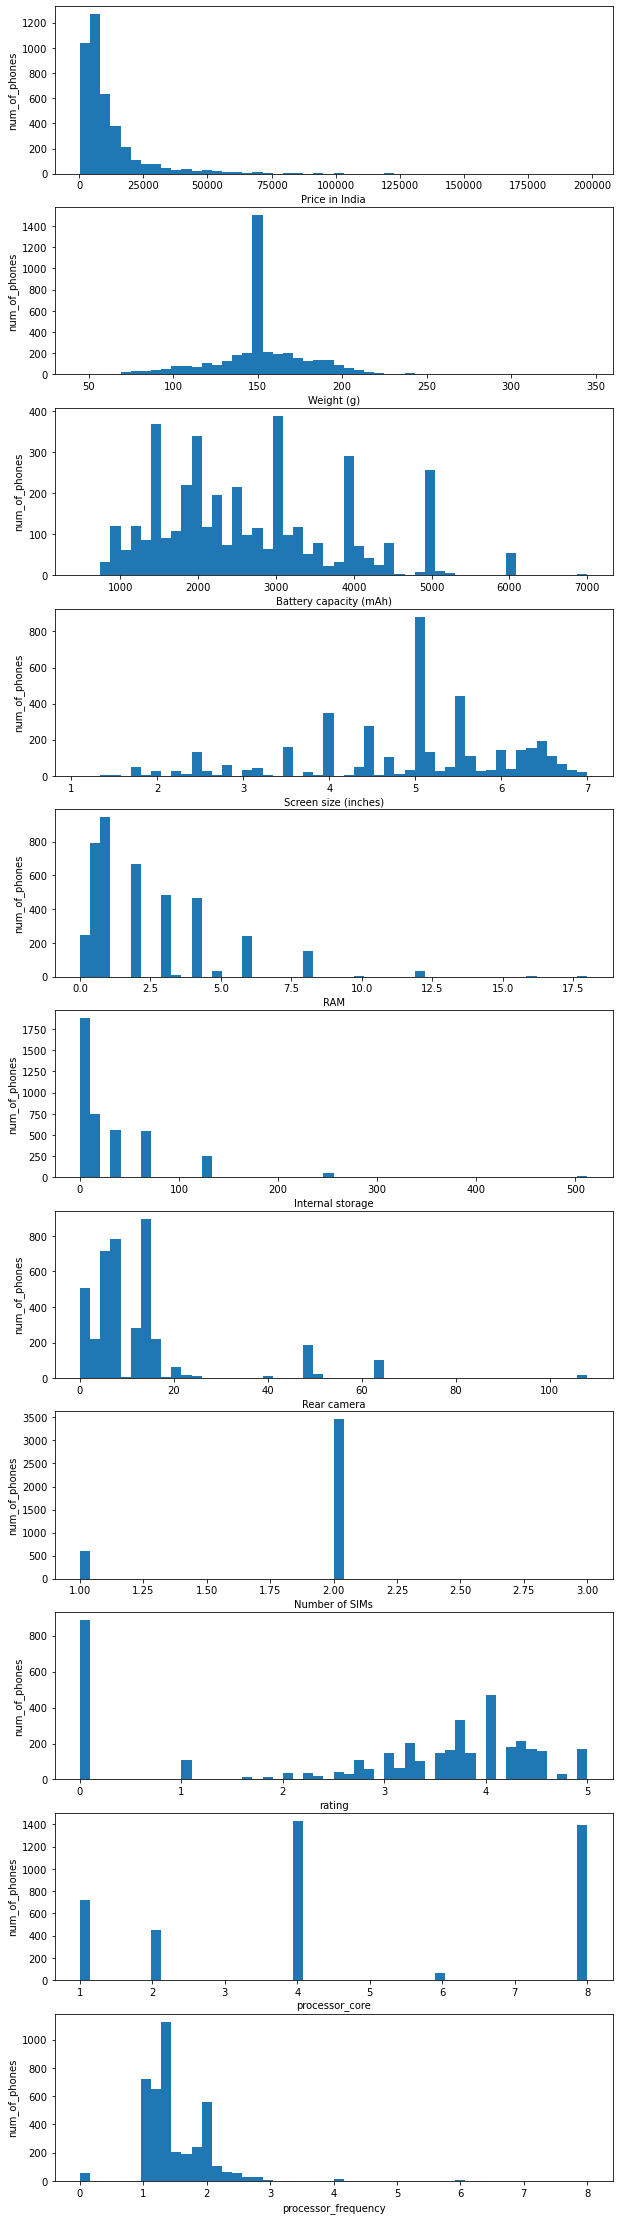

In [18]:
#Searching outliers in a graphic way
fig, axes = plt.subplots(df.describe().shape[1], figsize=(10,40))
for i,j in enumerate(df.describe()):    
    axes[i].hist(df[j], bins=50)
    axes[i].set(xlabel=j, ylabel='num_of_phones')
df=outliers_finder(df,['Screen size (inches)','Price in India'])


Text(0.5, 1.0, 'count by brand')

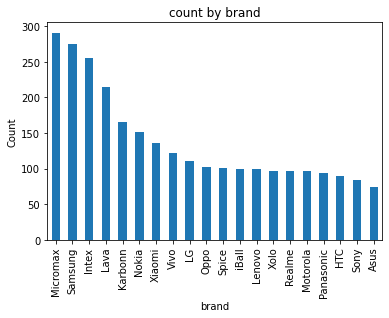

In [19]:
#Plotting phone amount by brands
df["Brand"].value_counts().nlargest(n=20).plot(kind='bar')
plt.ylabel('Count')
plt.xlabel('brand')
plt.title('count by brand')


Text(0.5, 1.0, 'phone by years')

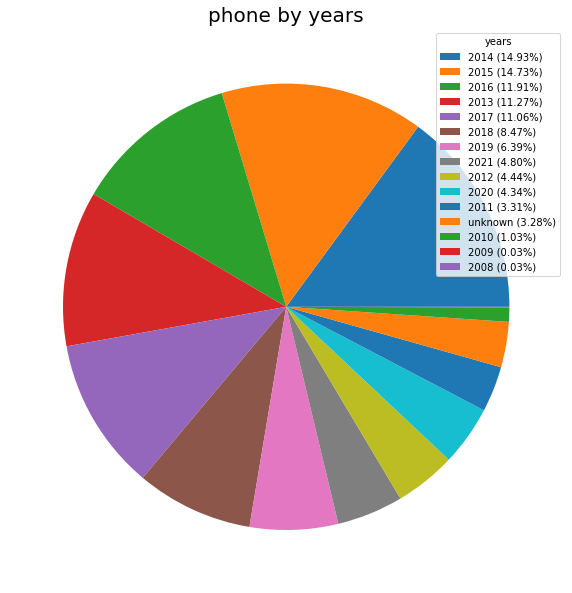

In [20]:
#Distribution of phones by year
df["Release date"].value_counts().plot(kind="pie",labels=None,figsize=(10,40))
legend = ['{} ({:.2%})'.format(idx, value) for idx, value in zip(df["Release date"].value_counts().index, df["Release date"].value_counts()/df.shape[0])]
plt.legend(legend,title="years",prop={"size":10},loc="upper right")
plt.ylabel("")
plt.title('phone by years',{"size":20})

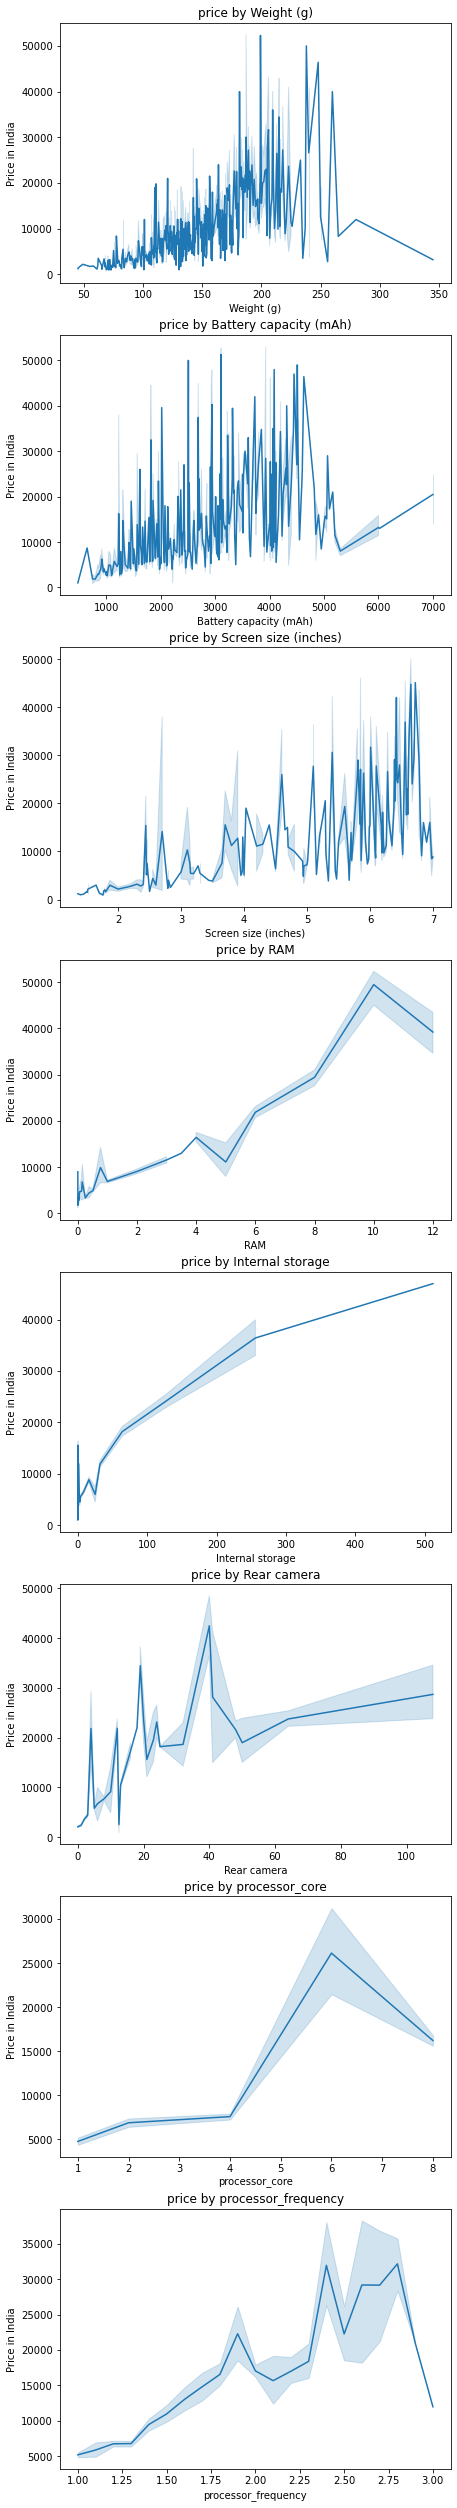

In [21]:
#Checking the connection between the price and various hardware properties
hardware=[ 'Weight (g)', 'Battery capacity (mAh)', 'Screen size (inches)','RAM', 'Internal storage', 'Rear camera',
       'processor_core', 'processor_frequency']
fig, axes = plt.subplots(len(hardware), figsize=(7,45))
for i,j in enumerate(hardware): 
    axes[i].title.set_text('price by '+j)
    sns.lineplot(data=df,x=j,y='Price in India',ax=axes[i])

<AxesSubplot:xlabel='rating', ylabel='Price in India'>

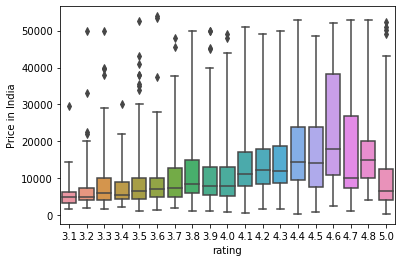

In [22]:
#Checking the connection between price and rating
sns.boxplot(df['rating'][df['rating']>3],df['Price in India'],whis=4)


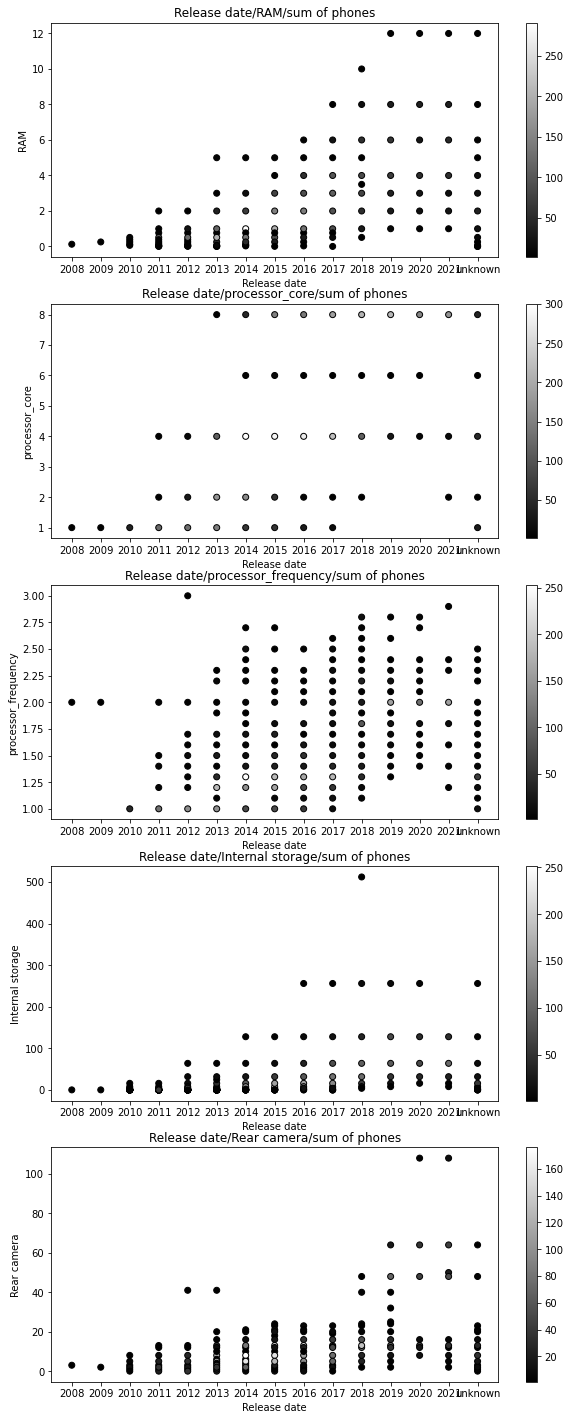

In [23]:
#Plots that show the connection between 3 parameters('Release date',hardware components,sum of phones)
k=['RAM', 'processor_core','processor_frequency','Internal storage','Rear camera']
fig, axes = plt.subplots(len(k), figsize=(10,25))
for i,j in enumerate(k):
    lst=df[["Release date",j]].value_counts().index
    r=lst.to_frame(name=["release date",j])
    r["counts"]=df[["Release date",j]].value_counts()
    r=r.sort_values("release date")
    x=axes[i].scatter(x=r["release date"],y=r[j],c=r["counts"], cmap="gray",edgecolors='black')
    fig.colorbar(x,ax=axes[i])
    axes[i].title.set_text("Release date/"+j+'/sum of phones')
    axes[i].set_xlabel("Release date")
    axes[i].set_ylabel(j)
    

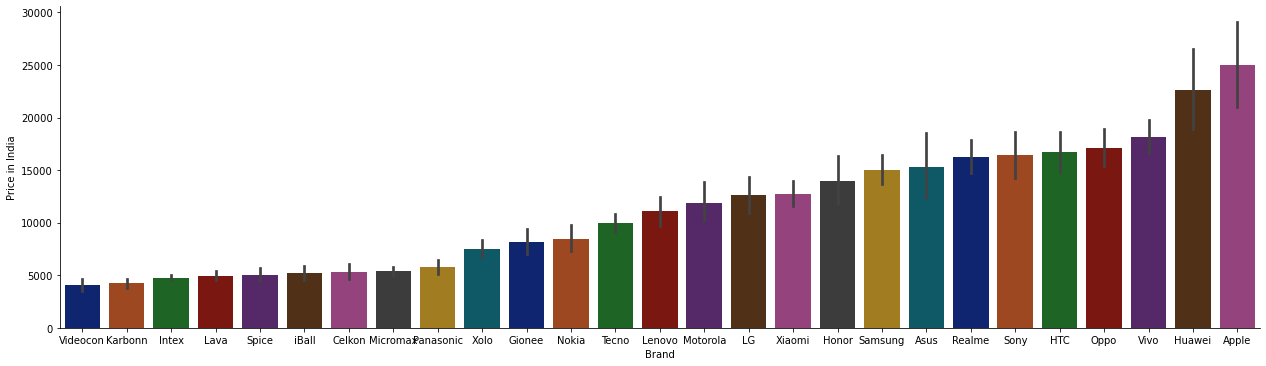

In [24]:
#distribution of average price of phones by brands
df12=pd.DataFrame()
largest_brands=df["Brand"].value_counts().nlargest(n=27).index
for i in largest_brands:
    df12=df12.append(df[df["Brand"]==i],ignore_index = True)
order = df12.groupby(["Brand"])["Price in India"].mean().sort_values().index
sns.catplot(data=df12, kind="bar",x=df12["Brand"], y=df12["Price in India"], palette="dark", height=5,aspect=3.5,order=order)

<AxesSubplot:xlabel='Price in India', ylabel='Release date'>

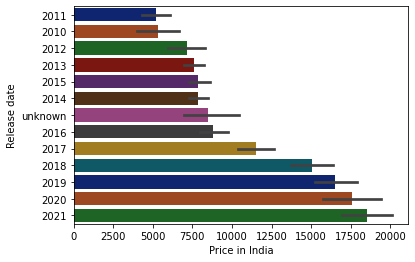

In [25]:
#distribution of average price of phones by years
order = df12.groupby(['Release date'])["Price in India"].mean().sort_values().index
sns.barplot(data=df12,x='Price in India',y=df12['Release date'].sort_values(), palette="dark",order=order)

In [26]:
df_linear=df.drop(['rating','url'],axis=1)

In [27]:
#Convert columns with string to numeric values for the machine learning 
def transfer_str_to_numeric_vals(df,str_col_list):
    dataset_new=df.copy()
    for str_col in str_col_list:
        tabs=dataset_new[str_col].astype('category').cat.categories.tolist()
        new={str_col:{x: y for x,y in zip(tabs,list(range(0,len(tabs)+1)))}}
        dataset_new.replace(new,inplace=True)
    return dataset_new

In [28]:
#splitting and training the dataframe and returning linear regression model
def split_and_train_df(df, target_column):
    y=df[target_column]
    X=df.drop(target_column, axis=1)
    X_train, X_test, y_train, y_test=train_test_split(X, y , test_size=0.3,random_state=43)
    trained_model=linear_model.LinearRegression(normalize=True).fit(X_train, y_train)
    return X_train, X_test, y_train, y_test, trained_model
    

In [29]:
str_col_list=list(df_linear.select_dtypes(['object']).columns)
df_linear=transfer_str_to_numeric_vals(df_linear,str_col_list)

In [30]:
X_train, X_test, y_train, y_test, trained_model=split_and_train_df(df_linear, 'Price in India')

In [31]:
#Evaluation of the model
y_pred=trained_model.predict(X_test)
evaluationmetric=r2_score(y_test,y_pred)
evaluationmetric

0.5996175841019473

In [32]:
dataframe=pd.DataFrame({'y_test':y_test,'y_pred':y_pred})
dataframe["sub"]=abs(dataframe['y_test']-dataframe['y_pred'])
dataframe.mean()

y_test    10702.595726
y_pred    10364.062589
sub        3864.946233
dtype: float64

In [33]:
#coefficient list
dictio=sorted(dict(zip(X_train.columns,abs(trained_model.coef_))).items(),key=lambda x: x[1])
dictio

[('Model', 0.17784571303298893),
 ('Battery capacity (mAh)', 0.623357743041935),
 ('Headphones', 8.734177055449223),
 ('Brand', 13.947913229931887),
 ('Weight (g)', 19.70931043905638),
 ('Accelerometer', 34.332493985305966),
 ('Internal storage', 35.89170762524792),
 ('Rear camera', 38.01876558030101),
 ('Bluetooth', 50.47100642973508),
 ('3G_2', 66.68655365460101),
 ('SIM Type', 66.90822413431582),
 ('Mobile High-Definition Link (MHL)', 146.50145179921728),
 ('processor_core', 172.9882543673808),
 ('Rear flash', 178.28223676996288),
 ('Wi-Fi Direct', 211.2584550673163),
 ('4G/ LTE_2', 264.9937434775811),
 ('Proximity sensor', 280.5267595433082),
 ('3G', 296.4642587051646),
 ('Gyroscope', 307.17932622364265),
 ('GSM/CDMA', 312.60871531597854),
 ('Form factor', 339.0313974226635),
 ('Release date', 436.5747493946447),
 ('GPS', 453.72131387837555),
 ('FM', 486.332917346562),
 ('4G/ LTE', 506.07043869268495),
 ('SIM Type_2', 534.408422696987),
 ('Touchscreen', 671.1523159589366),
 ('USB O

In [34]:
#manipulating the dataframe by adding columns and trying to improve our evaluation score
def manipulate_1st_feature_vector(df):
    manipulated_df=df.copy()
  
    manipulated_df['Screen size (inches)*processor_frequency']=df['Screen size (inches)']*df['processor_frequency']
    
    manipulated_df['USB OTG*processor_frequency']=df['USB OTG']*df['processor_frequency']
    
    manipulated_df['USB OTG*Expandable storage']=df['USB OTG']*df['Expandable storage']
    
    manipulated_df['RAM*processor_frequency']=df['RAM']*df['processor_frequency']

    return manipulated_df

In [35]:
manipulated_df=manipulate_1st_feature_vector(df_linear)
X_train, X_test, y_train, y_test, trained_model=split_and_train_df(manipulated_df, 'Price in India')
y_pred=trained_model.predict(X_test)
evaluationmetric=r2_score(y_test,y_pred)
evaluationmetric

0.6033712656394636

In [36]:
dataframe2=pd.DataFrame({'y_test':y_test,'y_pred':y_pred})
dataframe2["sub"]=abs(dataframe2['y_test']-dataframe2['y_pred'])
dataframe2

,y_test,y_pred,sub
2425,5189.0,6507.969276,1318.969276
5,24990.0,26836.257896,1846.257896
639,14990.0,16111.654273,1121.654273
814,5000.0,12077.791521,7077.791521
3478,7086.0,6998.170893,87.829107
...,...,...,...
2479,15819.0,8671.216747,7147.783253
3185,8998.0,10853.327733,1855.327733
1966,1399.0,1570.794319,171.794319
1893,7100.0,9879.196518,2779.196518


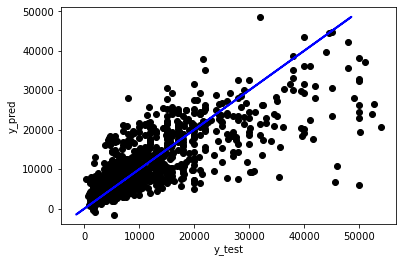

In [37]:
#Graph that shows us the connection between predicted price and original price, the line represent the linear regression model
plt.scatter(y_test, y_pred, color="black")
plt.plot(y_pred, y_pred, color="blue", linewidth=2)
plt.xlabel("y_test")
plt.ylabel('y_pred')
plt.show()

In [40]:
#Using CV to find the best parameter for Random Forest Regression
def find_best_random_forest_num_estimators(X_train, y_train):
    clf=RandomForestRegressor()
    CV3=GridSearchCV(clf,{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]},scoring=make_scorer(r2_score,greater_is_better=True))
    CV3.fit(X_train, y_train)
    return CV3.best_params_['n_estimators'],CV3.best_score_

In [41]:
#splitting and training the dataframe and returning Random Forest Regression model
def split_and_train_df_Forest(df, target_column):
    y=df[target_column]
    X=df.drop(target_column, axis=1)
    X_train, X_test, y_train, y_test=train_test_split(X, y , test_size=0.3,random_state=43)
    trained_model=RandomForestRegressor(n_estimators=1800,random_state=42).fit(X_train,y_train)
    return X_train, X_test, y_train, y_test, trained_model

In [42]:
#Evaluating the Random Forest Regression model
X_train_tree, X_test_tree, y_train_tree, y_test_tree, trained_model=split_and_train_df_Forest(df_linear, 'Price in India')
y_pred_tree=trained_model.predict(X_test_tree)
evaluationmetric=r2_score(y_test_tree,y_pred_tree)
evaluationmetric

0.6883213372732564

In [43]:
bestparam,bestscore=find_best_random_forest_num_estimators(X_train_tree, y_train_tree)
print(bestparam)
bestscore

1800


0.6496267631794441

In [44]:
dataframe3=pd.DataFrame({'y_test':y_test_tree,'y_pred':y_pred_tree})
dataframe3

,y_test,y_pred
2425,5189.0,7492.704375
5,24990.0,24786.108833
639,14990.0,14132.243125
814,5000.0,7878.198125
3478,7086.0,7901.719063
...,...,...
2479,15819.0,10412.315625
3185,8998.0,11563.660260
1966,1399.0,2307.375625
1893,7100.0,10782.005625


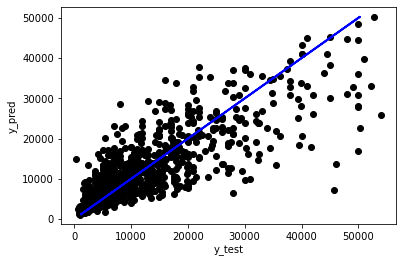

In [45]:
#Graph that shows us the connection between predicted price and original price, the line represent the Random Forest Regression model
plt.scatter(y_test_tree, y_pred_tree, color="black")
plt.plot(y_pred_tree, y_pred_tree, color="blue", linewidth=2)
plt.xlabel("y_test")
plt.ylabel('y_pred')
plt.show()

In [46]:
#Predicting the price to a new instances with our model
def predict_price(lst,df_linear,trained_model):
    df_linear3=df_linear.copy()
    df_linear3=df_linear3.append(lst,ignore_index=True)
    df_linear3.fillna(df_linear3.mode().iloc[0], inplace=True)
    str_col_list=list(df_linear3.select_dtypes(['object']).columns)
    df_linear3=transfer_str_to_numeric_vals(df_linear3,str_col_list)
    y_pred=trained_model.predict(df_linear3.iloc[-1,:].drop(['Price in India',"url","rating"]).to_numpy().reshape(1,-1))
    return y_pred,df_linear3.iloc[-1,:].drop(['Price in India',"url","rating"])

In [47]:
#New instances to predict the price
prediction,x=predict_price({'Brand':'Samsung','Model':'pelephone','RAM':16,'processor_core':6,'NFC':'Yes','Number of SIMs':2},df,trained_model)
print("the prediction price with given parameter is:",prediction)
prediction,x=predict_price({'Brand':'Xiaomi','Model':'pocopoco','RAM':2,'processor_core':1,'NFC':'No','Number of SIMs':1},df,trained_model)
print("the prediction price with given parameter is:",prediction)
prediction,x=predict_price({'Brand':'ZTE','Model':'pikachi','RAM':12,'processor_core':8,'NFC':'Yes','Number of SIMs':3},df,trained_model)
print("the prediction price with given parameter is:",prediction)
prediction,x=predict_price({'Brand':'Asus','Model':'x3845','RAM':8,'processor_core':4,'NFC':'Yes','Number of SIMs':1},df,trained_model)
print("the prediction price with given parameter is:",prediction)

the prediction price with given parameter is: [17869.46161458]
the prediction price with given parameter is: [8198.055]
the prediction price with given parameter is: [18517.38614583]
the prediction price with given parameter is: [18054.16958333]
